In [3]:
#                              PROJECT: FAKE NEWS DETECTION, PROBLEM TYPE: BINARY CLASSIFICATION
##                            FEATURES: LOGISTIC REGRESSION & BASIC LSTM MODEL

#   IMPORTING DEPENDENCIES
import numpy as np    # Used in creating numpy arrays
import pandas as pd   # Used in creating data frames and storing data in them
import re             # Used for searching text in a document
from nltk.corpus import stopwords     # Natural Language Toolkit, removes common words like 'the', 'a', 'an'
from nltk.stem.porter import PorterStemmer    # Stemming takes a word, removes prefix/suffix, returns root
from sklearn.feature_extraction.text import TfidfVectorizer   # Converting text to numbers
from sklearn.model_selection import train_test_split    # Splitting data into training and test data
from sklearn.linear_model import LogisticRegression   # Basic classification model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report    # Used for accuracy and reporting
import nltk
nltk.download('stopwords')
from tqdm import tqdm   # Used to monitor processing and pre-processing of data
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [4]:
#   IMPORTS FOR LSTM
import matplotlib
print(matplotlib.__version__)
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

3.9.2


In [5]:
# ============================= DATA COLLECTION AND DATA PRE-PROCESSING =============================
news_dataset = pd.read_csv(r"C:\Users\HP\Desktop\fake_news\fake-news\train.csv")
news_dataset = news_dataset.fillna("")  # Fill null values with empty string
news_dataset['content'] = news_dataset['text']  # Use full article text for prediction

In [6]:
#                              EXTRACT RAW TEXTS & LABELS FOR LSTM PROCESSING                                  
texts = news_dataset['content'].astype(str).values  # ENSURE TEXT IS STRING TYPE
labels = news_dataset['label'].values  # 1 = FAKE NEWS, 0 = REAL NEWS

In [7]:
# =============================NUMBER MASKING + STEMMING =============================
port_stem = PorterStemmer()
stop_words = set(stopwords.words('english'))

def mask_numbers(text):
    """Replace all digit sequences with a special <NUM> token."""
    return re.sub(r"\d+", " <NUM> ", text)

In [8]:
#   STEMMING PROCEDURE WITH NUMBER MASKING

def stemming(content):
    # Mask numbers first
    content = mask_numbers(content)
    # Remove non-alphabetic and non-<NUM> characters
    content = re.sub('[^a-zA-Z <>NUM]', ' ', content)
    # Convert to lowercase and split
    stemmed = content.lower().split()
    # Apply stemming and remove stopwords
    stemmed = [port_stem.stem(w) for w in stemmed if w not in stop_words]
    return ' '.join(stemmed)

# Apply stemming with number masking
news_dataset['content'] = news_dataset['content'].progress_apply(stemming)

100%|████████████████████████████████████████████████████████████████████████████| 20800/20800 [10:44<00:00, 32.29it/s]


In [9]:
# ============================= PREPARE DATA FOR LOGISTIC REGRESSION MODEL =============================
#   TFIDF = Term Frequency-Inverse Document Frequency

tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 words for simplicity
X_tfidf = tfidf_vectorizer.fit_transform(news_dataset['content'])
y = news_dataset['label'].values  # 1 = Fake News, 0 = Real News

In [10]:
# ============================= SPLIT DATA FOR LOGISTIC REGRESSION MODEL =============================
#   80% training data, 20% testing data
X_train_tfidf, X_test_tfidf, Y_train, Y_test = train_test_split(
    X_tfidf, y, test_size=0.2, stratify=y, random_state=2)

In [11]:
# ============================= TRAIN LOGISTIC REGRESSION MODEL =============================
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train_tfidf, Y_train)

LogisticRegression(max_iter=200)

Logistic Regression Test Accuracy: 94.13461538461539

Confusion Matrix:
[[1951  126]
 [ 118 1965]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2077
           1       0.94      0.94      0.94      2083

    accuracy                           0.94      4160
   macro avg       0.94      0.94      0.94      4160
weighted avg       0.94      0.94      0.94      4160



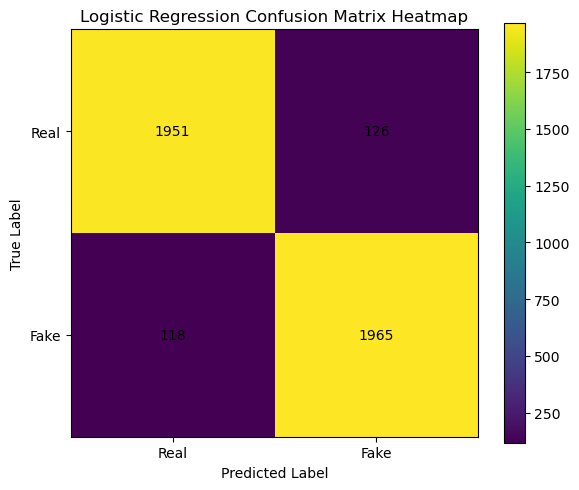

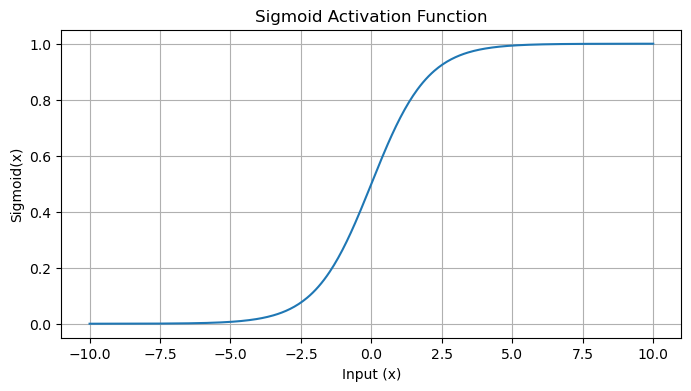

Optimal Threshold by Youden's J: 0.5595


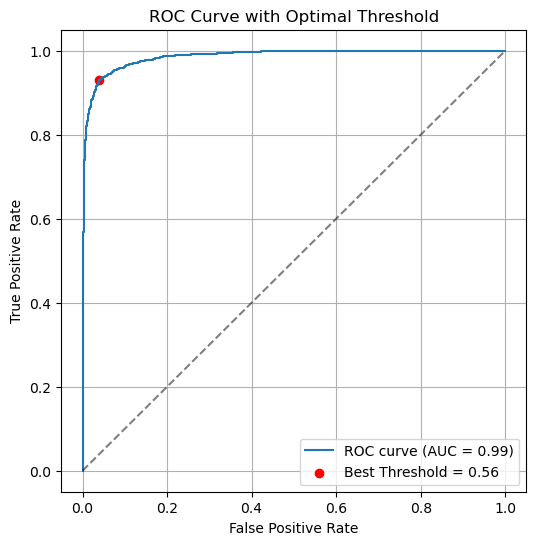

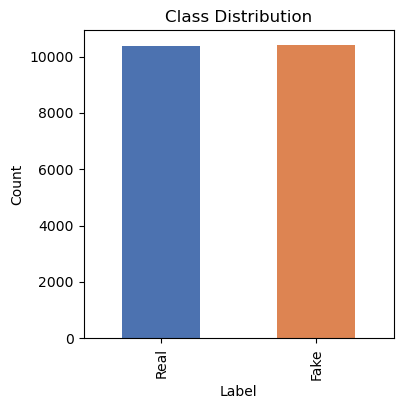

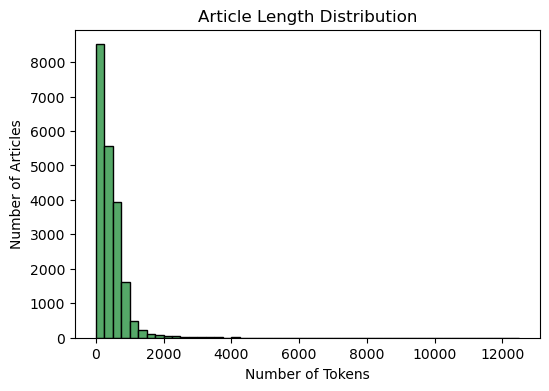

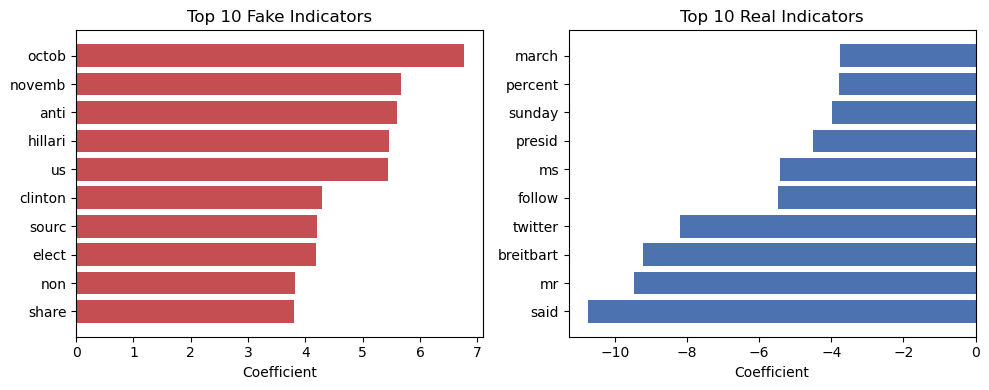

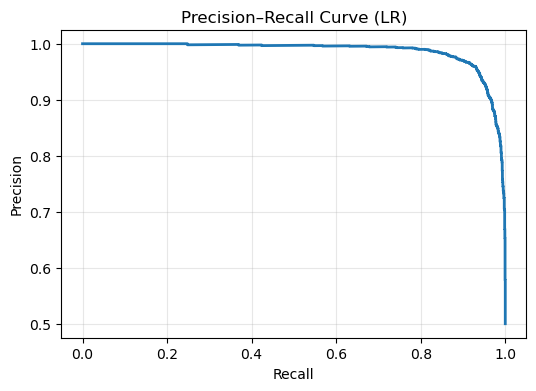

In [18]:
# ============================= LOGISTIC REGRESSION MODEL EVALUATION =============================
print('Logistic Regression Test Accuracy:', accuracy_score(Y_test, lr_model.predict(X_test_tfidf))*100)
print('\nConfusion Matrix:')
print(confusion_matrix(Y_test, lr_model.predict(X_test_tfidf)))
print('\nClassification Report:')
print(classification_report(Y_test, lr_model.predict(X_test_tfidf)))

import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

# 1) Get LR predictions on the test set
y_pred_lr = lr_model.predict(X_test_tfidf)

# 2) Compute confusion matrix
cm = confusion_matrix(Y_test, y_pred_lr)

# 3) Plot heatmap
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title('Logistic Regression Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 4) Tick labels
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Real', 'Fake'])
plt.yticks(tick_marks, ['Real', 'Fake'])

# 5) Annotate each cell with its count
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, str(cm[i, j]), ha='center', va='center')

# 6) Colorbar and layout
plt.colorbar()
plt.tight_layout()
plt.show()

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Generate input values
x = np.linspace(-10, 10, 400)
y = sigmoid(x)

# Plot the sigmoid curve
plt.figure(figsize=(8, 4))
plt.plot(x, y)
plt.title('Sigmoid Activation Function')
plt.xlabel('Input (x)')
plt.ylabel('Sigmoid(x)')
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Compute predicted probabilities for the positive (fake) class
y_probs = lr_model.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(Y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Compute Youden's J statistic and find optimal threshold
j_scores = tpr - fpr
ix = np.argmax(j_scores)
best_threshold = thresholds[ix]

# Print the optimal threshold
print(f"Optimal Threshold by Youden's J: {best_threshold:.4f}")

# Plot ROC curve with optimal threshold annotated
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr[ix], tpr[ix], c='red', label=f'Best Threshold = {best_threshold:.2f}')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Optimal Threshold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve

# --- 1) Class Distribution ---
plt.figure(figsize=(4,4))
news_dataset['label'].value_counts().sort_index().plot(kind='bar', color=['#4c72b0','#dd8452'])
plt.xticks([0,1], ['Real','Fake'])
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# --- 2) Article‑Length Distribution (in tokens) ---
lengths = news_dataset['content'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6,4))
plt.hist(lengths, bins=50, color='#55a868', edgecolor='k')
plt.title('Article Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Articles')
plt.show()

# --- 3) Top TF‑IDF Features per Class (LR Coefficients) ---
feature_names = tfidf_vectorizer.get_feature_names_out()
coefs = lr_model.coef_[0]

# Top 10 fake indicators (highest positive weights)
top_fake_idx = np.argsort(coefs)[-10:]
# Top 10 real indicators (most negative weights)
top_real_idx = np.argsort(coefs)[:10]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.barh(feature_names[top_fake_idx], coefs[top_fake_idx], color='#c44e52')
plt.title('Top 10 Fake Indicators')
plt.xlabel('Coefficient')

plt.subplot(1,2,2)
plt.barh(feature_names[top_real_idx], coefs[top_real_idx], color='#4c72b0')
plt.title('Top 10 Real Indicators')
plt.xlabel('Coefficient')

plt.tight_layout()
plt.show()

# --- 4) Precision–Recall Curve for Logistic Regression ---
y_probs = lr_model.predict_proba(X_test_tfidf)[:, 1]
precision, recall, _ = precision_recall_curve(Y_test, y_probs)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, lw=2)
plt.title('Precision–Recall Curve (LR)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(alpha=0.3)
plt.show()


In [21]:
# ============================= LSTM SIDE =============================
#   Start from a clean slate

# 1) Prepare your data
tf.keras.backend.clear_session()
texts = news_dataset['content'].astype(str).values  # Ensure text is string type
labels = news_dataset['label'].values

seq_X_train, seq_X_test, seq_y_train, seq_y_test = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=2)

In [22]:
# 2) Tokenize & pad
max_words = 50000
max_length = 200

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(seq_X_train)

X_train_padded = pad_sequences(
    tokenizer.texts_to_sequences(seq_X_train),
    maxlen=max_length, padding='post', truncating='post'
)
X_test_padded = pad_sequences(
    tokenizer.texts_to_sequences(seq_X_test),
    maxlen=max_length, padding='post', truncating='post'
)

In [23]:
# 3) Build the LSTM with recurrent_dropout + higher dropout
vocab_size = min(max_words, len(tokenizer.word_index) + 1)

epochs = 20
embedding_dim = 100
model = Sequential([
    Embedding(vocab_size, embedding_dim),
    LSTM(128, return_sequences=True, recurrent_dropout=0.2),
    Dropout(0.3),
    LSTM(64, recurrent_dropout=0.2),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [24]:
# 4) EarlyStopping to halt & restore best weights
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train
history = model.fit(
    X_train_padded, seq_y_train,
    epochs=epochs,
    batch_size=32,
    validation_data=(X_test_padded, seq_y_test),
    callbacks=[early_stop]
)

Epoch 1/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 359s 662ms/step - accuracy: 0.7024 - loss: 0.5904 - val_accuracy: 0.8161 - val_loss: 0.4440
Epoch 2/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 337s 648ms/step - accuracy: 0.8418 - loss: 0.3831 - val_accuracy: 0.8721 - val_loss: 0.3056
Epoch 3/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 331s 637ms/step - accuracy: 0.9161 - loss: 0.2194 - val_accuracy: 0.9123 - val_loss: 0.2265
Epoch 4/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 340s 654ms/step - accuracy: 0.9631 - loss: 0.1063 - val_accuracy: 0.9272 - val_loss: 0.2031
Epoch 5/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 332s 639ms/step - accuracy: 0.9840 - loss: 0.0574 - val_accuracy: 0.9310 - val_loss: 0.2273
Epoch 6/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 336s 645ms/step - accuracy: 0.9902 - loss: 0.0333 - val_accuracy: 0.9305 - val_loss: 0.2078
Epoch 7/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 333s 640ms/step - accuracy: 0.9924 - loss: 0.0270 - val_accuracy: 0.9365 - val_loss: 0.2208


In [25]:
# 5) Evaluate
test_loss, test_acc = model.evaluate(X_test_padded, seq_y_test)
print(f"\nTest accuracy (best): {test_acc:.4f}")

130/130 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 0.9220 - loss: 0.2178

Test accuracy (best): 0.9272


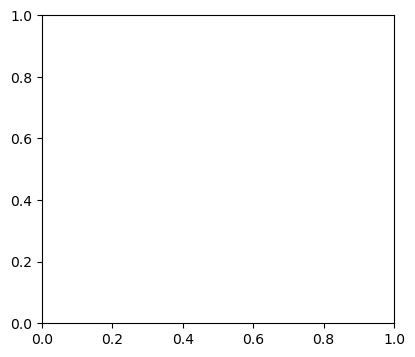

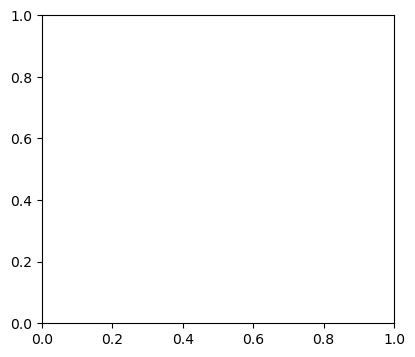

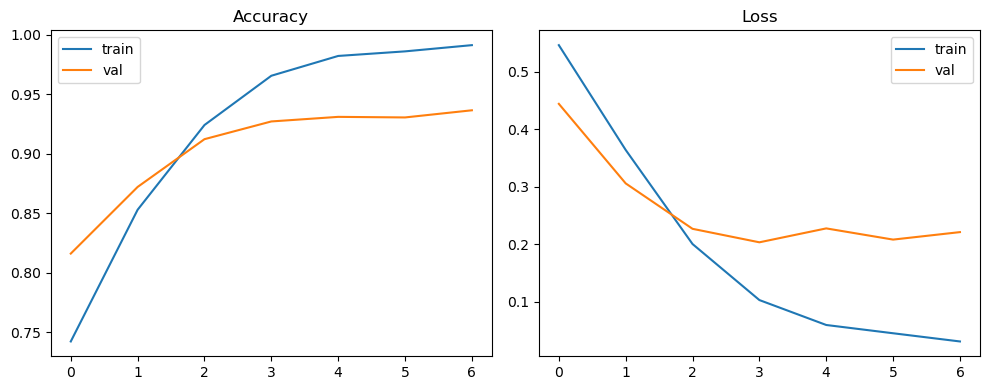

In [26]:
# Plot training vs validation
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# 6) Classification report & confusion matrix
y_pred_binary = (model.predict(X_test_padded) > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(seq_y_test, y_pred_binary))
print("Confusion Matrix:")
print(confusion_matrix(seq_y_test, y_pred_binary))

130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2077
           1       0.94      0.92      0.93      2083

    accuracy                           0.93      4160
   macro avg       0.93      0.93      0.93      4160
weighted avg       0.93      0.93      0.93      4160

Confusion Matrix:
[[1948  129]
 [ 174 1909]]


In [28]:
# ============================= NEW FUNCTION: PREDICT ARBITRARY PARAGRAPH =============================
def predict_paragraph(paragraph: str):
    """Return fake-news probabilities from LR and LSTM for any raw paragraph."""
    # Apply identical preprocessing
    proc = stemming(paragraph)

    # Logistic Regression prediction
    X_lr = tfidf_vectorizer.transform([proc])
    prob_fake_lr = lr_model.predict_proba(X_lr)[0][1]

    # LSTM prediction
    seq = pad_sequences(
        tokenizer.texts_to_sequences([proc]),
        maxlen=max_length, padding='post', truncating='post'
    )
    prob_fake_lstm = model.predict(seq)[0][0]

    print(f"Logistic Regression --> P(fake)={prob_fake_lr:.4f}, P(real)={1-prob_fake_lr:.4f}")
    print(f"LSTM                   --> P(fake)={prob_fake_lstm:.4f}, P(real)={1-prob_fake_lstm:.4f}")

    return prob_fake_lr, prob_fake_lstm

In [29]:
sample_para=("The European Commission has approved a comprehensive set of climate regulations yesterday following 14 months of negotiations between member states. The new framework, known as the European Green Directive, will require a 55% reduction in carbon emissions by 2030 compared to 1990 levels across all 27 member states. This represents the most ambitious climate legislation in the world, said Commission President Ursula von der Leyen at the Brussels press conference. The package includes 750 billion in funding for renewable energy projects, with particular focus on helping Eastern European countries transition away from coal power. Industry representatives expressed mixed reactions, with the European Automobile Manufacturers Association requesting additional time to meet new vehicle emission standards, while renewable energy companies praised the investment certainty the regulations provide")
predict_paragraph(sample_para)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Logistic Regression --> P(fake)=0.1896, P(real)=0.8104
LSTM                   --> P(fake)=0.0175, P(real)=0.9825


(0.18956885489604083, 0.017482407)

In [30]:
sample_para= """BREAKING: Secret Government Program Uses Weather Stations to Control Local Climate

Internal documents leaked by an anonymous whistleblower reveal that ordinary weather stations across the country have been secretly equipped with climate modification technology since 2018. The program, code-named "Project Celsius," allows government operators to manipulate local weather patterns through a network of over 2,500 modified stations disguised as standard meteorological equipment.

According to former Department of Energy scientist Dr. Robert Carmichael, who left the agency in 2019, the stations emit specialized radio frequencies that can influence cloud formation and precipitation. "What they told the public was these were upgrades to improve weather forecasting accuracy, but the real purpose was to gain the ability to trigger rainfall during droughts or prevent it during flood seasons," Carmichael explained in an exclusive interview.

The leaked documents show the program has cost taxpayers $3.7 billion over five years, with funds hidden in multiple agency budgets under misleading line items. Several unexplained weather anomalies in the Midwest have been linked to test operations of the system. Farmers in affected areas reported unusual crop growth patterns and sudden, localized storms that meteorologists could not explain through natural weather models.

When contacted about Project Celsius, government officials denied its existence. A spokesperson for the National Weather Service stated that "no such capabilities exist" and dismissed the claims as "completely unfounded." However, three independent experts who reviewed the technical specifications in the leaked documents confirmed the technology is theoretically possible and consistent with classified research conducted in the early 2010s.

Citizen groups are demanding congressional hearings and have launched a petition that has already gathered over 50,000 signatures. Environmental activists worry about potential ecological consequences of artificial weather manipulation, while privacy advocates raise concerns about government overreach."""
predict_paragraph(sample_para)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Logistic Regression --> P(fake)=0.6882, P(real)=0.3118
LSTM                   --> P(fake)=0.9082, P(real)=0.0918


(0.6882299434570306, 0.90819204)